<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Time_Series_Lista_de_Exerc%C3%ADcios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

## Data Loader

In [44]:
!pip install yfinance

In [45]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta  # Para calcular data de um ano atrás
from typing import Literal # Para anotação dos argumentos de funções

class DataLoader:
  '''
  Esta classe carrega dos dados de precificação de ativos e os coloca em um
  mesmo padrão a ser usado em todo o projeto, qual seja, um DataFrame com a
  seguinte estrutura:
    #   Column     Dtype            Descrição
    ---  ------    -----            ---------
    0   ds         datetime64[ns]   Data da observação
    1   y          float64          Observação (variável alvo)
    2   unique_id  str              Identificador da série temporal

  '''
  FREQ_VALUES = ['d', 'W','ME','Q','y']

  @staticmethod
  def stand(df: pd.DataFrame, symbol:str, col_ds='date', col_y='close', value_id=None) -> pd.DataFrame:
    '''
    Esta função padroniza o DataFrame para que fique
    no formato esperado pelo restante deste notebook.
    '''

    # Garantir que "date" seja uma coluna normal
    df = df.reset_index()
    # Converter nomes das colunas para minúsculas
    df.columns = df.columns.str.lower()
    col_ds = col_ds.lower()
    col_y = col_y.lower()
    # Padronizando no nome das colunas
    df.drop(columns=df.columns.difference([col_ds, col_y]), inplace=True)

    df.rename(columns={col_ds: 'ds', col_y: 'y'}, inplace=True)

    df['y'] = df['y'].astype(float)
    # Converter a coluna 'ds' para datetime, caso não esteja nesse formato
    df['ds'] = pd.to_datetime(df['ds'])

    df['unique_id'] = symbol if value_id is None else value_id
    # Convertendo a coluna 'coluna' para string
    df['unique_id'] = df['unique_id'].astype(str)
    return df


  # Carregar dados a partir do sistema de arquivos
  def from_csv(self, path, symbol='ativo', col_ds='ds', col_y='y', value_id='ativo', delimiter=',', decimal='.', dayfirst=False):
      df = pd.read_csv(path, parse_dates=[col_ds], index_col=col_ds, delimiter=delimiter, decimal=decimal, dayfirst=dayfirst)
      df = self.stand(df, symbol=symbol, col_ds=col_ds, col_y=col_y, value_id=value_id)

      return df

  # Carregar os dados a partir do Yahoo Finance.
  class __YahooFinance:
    @staticmethod
    def get(symbol:str, start_date:datetime, end_date:datetime = None) -> DataFrame:
      '''
      Esta função carrega os dados diários de um ativo a partir do Yahoo Finance.
      '''
      import yfinance as yf
      df = yf.download(tickers=symbol, start=start_date, end=end_date)
      # Garantir que as colunas não sejam MultiIndex
      if isinstance(df.columns, pd.MultiIndex):
          # Remove o segundo nível do MultiIndex,
          # pois ele contém apenas o símbolo do ativo,
          # não acrescentando valor semântico aqui,
          # já que só trabalhamos com um ativo por vez.
          df = df.droplevel(1, axis=1)
      # Remove o nome do MultiIndex ("Price")
      df.columns.name = None

      return df

  def from_yahoo(self, symbol:str, start_date:datetime, end_date:datetime = None, col_y='close', value_id=None) -> DataFrame:
    df = self.__YahooFinance.get(symbol=symbol, start_date=start_date, end_date = end_date)
    df = self.stand(df, symbol=symbol, col_y=col_y, value_id=value_id)

    return df


  @staticmethod
  def infer_freq(df:pd.DataFrame) -> str:
    """
    Infere a frequência dos dados com base na diferença mais comum entre as datas.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo uma coluna de datas.

    Retorna:
    str: Frequência inferida ('d', 'W', 'ME', 'Q', 'y').

    Lança:
    ValueError: Se não for possível inferir a frequência.
    """
    if 'y' not in df.columns:
        raise ValueError(f"A coluna 'y' não existe no DataFrame.")

    if 'ds' not in df.columns:
        raise ValueError(f"A coluna 'ds' não existe no DataFrame.")

    # Verifica se a coluna é do tipo datetime
    if df['ds'].dtype != 'datetime64[ns]':
        raise ValueError(f"A coluna 'ds' não é do tipo datetime64: {df['ds'].dtype}")

    # Calcular a diferença entre datas consecutivas
    dias = df['ds'].dropna().diff().mode()[0].days

    if dias == 1:
        return 'd'  # Diário
    elif dias == 7:
        return 'W'  # Semanal
    elif dias in [28, 29, 30, 31]:  # Considerando variações mensais
        return 'ME'  # Mensal
    elif dias in [90, 91, 92, 93]:  # Considerando variações trimestrais
        return 'Q'  # Trimestral
    elif dias in [365, 366]:  # Considerando anos bissextos
        return 'y'  # Anual
    else:
        raise ValueError(f"Não foi possível inferir a frequência. Diferença mais comum: {dias} dias.")

  @staticmethod
  def resample(df:pd.DataFrame, freq:Literal['d','W','ME','Q','y']) -> pd.DataFrame:

    if freq not in  DataLoader.FREQ_VALUES:
      raise Exception(f'Valor de freq ({freq}) inválido! Use um dos seguintes valores: {DataLoader.FREQ_VALUES}.')

    df = df.copy()

    # Inferindo a frequencia atual do dataframe.
    actual_freq = DataLoader.infer_freq(df)

    # Setando o índice e a frequência da coluna 'ds'.
    df = df.set_index('ds').asfreq(actual_freq)

    # Alterando o dataframe para a frequência solicitada.
    df = df.resample(freq).last() #df.groupby(pd.Grouper(key='ds', freq=actual_freq))['y'].sum()

    df = df.reset_index()

    return df

  @staticmethod
  def find_target(df, col_y):
    return next((col for col in df.columns if col == col_y or col.endswith('_'+col_y) or col.startswith(col_y+'_')))

loader = DataLoader()

In [46]:
start_date = datetime(2010, 3, 18)
end_date = datetime (2025, 3, 18)

df =loader.from_yahoo(symbol='BTC-USD', start_date=start_date, end_date = end_date)
df = loader.resample(df, freq='ME')

[*********************100%***********************]  1 of 1 completed


In [47]:
df

,ds,y,unique_id
0,2014-09-30,386.944000,BTC-USD
1,2014-10-31,338.321014,BTC-USD
2,2014-11-30,378.046997,BTC-USD
3,2014-12-31,320.192993,BTC-USD
4,2015-01-31,217.464005,BTC-USD
...,...,...,...
122,2024-11-30,96449.054688,BTC-USD
123,2024-12-31,93429.203125,BTC-USD
124,2025-01-31,102405.023438,BTC-USD
125,2025-02-28,84373.007812,BTC-USD


## Separação em treinamento e teste

In [48]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
train['unique_id'] = 'train'
test['unique_id'] = 'test'
print(train.shape)
print(test.shape)

(88, 3)
(39, 3)


<ipython-input-48-81d3be444d1c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-81d3be444d1c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Plotter

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Plotter:
  """
  Classe responsável por gerar gráficos de séries temporais utilizando Matplotlib e Plotly.

  Métodos:
  --------
  - `plotly()`: Plota séries temporais interativas com Plotly, melhor de ver em desktops.
  - `__stand()`: Padroniza a estrutura dos DataFrames.
  """


  def plotly(self, dfs=[], title='Séries Temporais', col_ds='ds', col_y='y', colors=None):
      """
      Plota múltiplas séries temporais utilizando Plotly.

      Parâmetros:
      -----------
      dfs : list of pandas.DataFrame, opcional
          Lista de pd.DataFrames ou pd.Series, contendo séries temporais. Cada elemento da lista
          deve ter pelo menos duas colunas:
          - Uma coluna representando a variável temporal (definida por `col_ds`).
          - Uma coluna com os valores da série temporal (definida por `col_y`).
      title (str): Título do gráfico. Padrão: 'Séries Temporais'.
      col_ds (str): Nome da coluna com as datas. Padrão: 'ds'.
      col_y (str): Nome da coluna com os valores numéricos. Padrão: 'y'.
      colors : Lista de cores para diferenciar as séries temporais no gráfico. Se fornecida, cada série será atribuída
        a uma cor da lista de forma cíclica. Caso contrário, cores padrão do Plotly serão usadas.
      """
      import plotly.graph_objects as go

      # Normaliza 'dfs' como DataFrames
      dfs = self.__stand(dfs, col_ds=col_ds, col_y=col_y)
      # Criando figura
      fig = go.Figure()
      # O comando a seguir percorre a lista dfs e adiciona
      # a coluna 'unique_id' em cada um, caso ela não exista.
      for i, df in enumerate(dfs, start=0):
        #unique_id = df.get(col_unique_id, i)
        #df[col_unique_id] = unique_id
        # Obtém a cor da linha principal, se fornecida
        color = colors[i % len(colors)] if colors else None

        # Adiciona a linha principal da série
        # Identificando o nome completo da coluna alvo
        col_target = DataLoader.find_target(df, col_y)
        fig.add_trace(go.Scatter(
            x=df[col_ds], y=df[col_target],
            mode="lines", name=col_target, line=dict(width=1, color=color)
        ))


        # Intervalo de Confiança
        col_upper=next((col for col in df.columns if '-hi-' in col),None)
        col_lower= next((col for col in df.columns if '-lo-' in col),None)
        # Se os dois extremos do intervalo de confiança foram definidos,
        # adicione-o como uma faixa preenchida.
        if (col_upper is not None and col_lower is not None):

          # Definindo a cor da sobra do intervalo de confiança, a partir da cor da linha principal
          shadow_color = None
          if (color is not None):
            from matplotlib import colors as mcolors
            rgba = mcolors.to_rgba(color, alpha=0.2)  # Define opacidade de 20%
            shadow_color = f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

          fig.add_trace(go.Scatter(
              x=df[col_ds], y=df[col_upper],
              mode='lines', line=dict(width=0), # Linha invisível
              showlegend=False
          ))

          fig.add_trace(go.Scatter(
              x=df[col_ds], y=df[col_lower],
              mode='lines', line=dict(width=0), # Linha invisível
              fill='tonexty', fillcolor=shadow_color, # Sombra no tom da linha principal
              showlegend=True, name=col_lower.replace('-lo-','_level_')
          ))
      # Ajustando legenda para o topo
      fig.update_layout(margin=dict(l=10, r=10, t=50, b=50), legend_font_size=12)

      fig.show()

  def __stand(self, dfs, col_ds, col_y) -> pd.DataFrame:
    """
    Padroniza a estrutura de dados fornecida.

    Parâmetros:
    -----------
    dfs : list of pandas.DataFrame or list of pandas.Series
    """

    for i, df in enumerate(dfs, start=1):
      if isinstance(df, pd.Series):
        #print(f'before to_frame() \n {df}')
        df = df.to_frame()
        #print(f'after to_frame() \n {df}')
        dfs[i-1] = df
      if not isinstance(df, pd.DataFrame):
        raise Exception(f"A variável dfs[{i-1}] não é do tipo DataFrame ou Series:\n{print(type(dfs[i-1]))}\n{dfs[i-1]}")
      df = df.reset_index()
      dfs[i-1] = df

      cols = [col for col in df.columns if col == col_y or col.endswith('_'+col_y) or col.startswith(col_y+'_')]
      if len(cols)!=1:
        raise Exception(f"A variável dfs[{i-1}] não contém apenas uma coluna '{col_y}' ou '*-{col_y}':{df.columns}\n{dfs[i-1]}")
      if col_ds not in df.columns:
        raise Exception(f"A variável dfs[{i-1}] não contém a coluna '{col_ds}':{df.columns}\n{dfs[i-1]}")

    return dfs

plotter=Plotter()

In [50]:
plotter.plotly([train])

# Correlation

In [51]:
!pip install pmdarima statsmodels scikit-learn

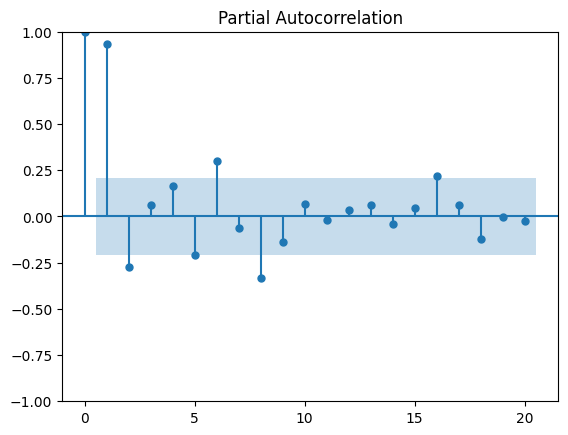

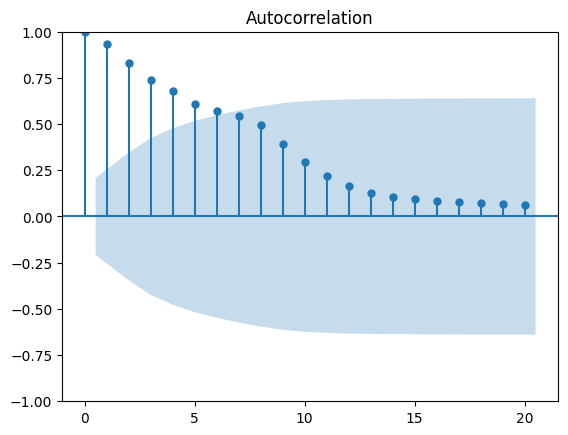

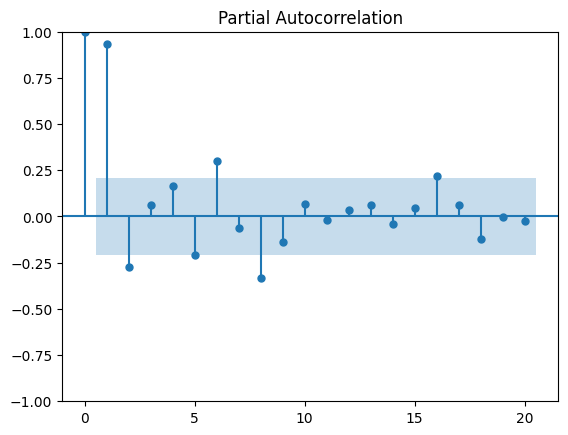

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train['y'])
plot_pacf(train['y'])

# Diferenciações

In [53]:
diff1 = train['y'].diff(1).dropna()
diff1


,y
1,-48.622986
2,39.725983
3,-57.854004
4,-102.728989
5,36.798996
...,...
83,5540.492188
84,-3375.792969
85,17528.062500
86,-4313.531250


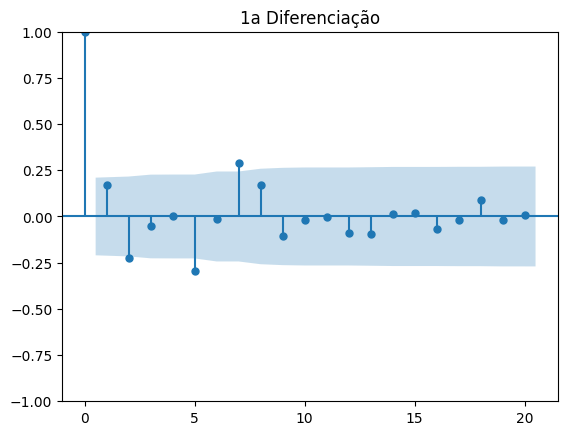

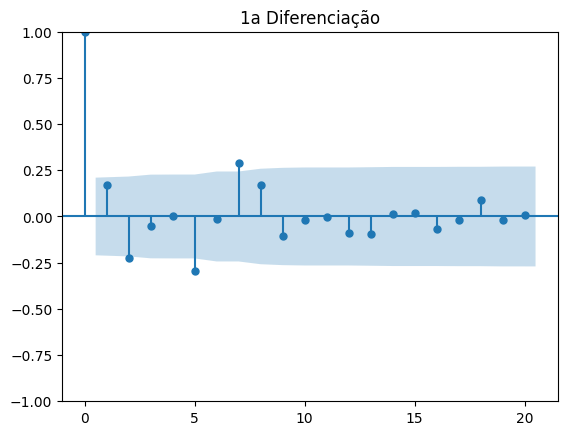

In [54]:
plot_acf(diff1, title='1a Diferenciação')

In [55]:
diff2 = diff1.diff(1).dropna()
diff2


,y
2,88.348969
3,-97.579987
4,-44.874985
5,139.527985
6,-46.837997
...,...
83,-1044.867188
84,-8916.285156
85,20903.855469
86,-21841.593750


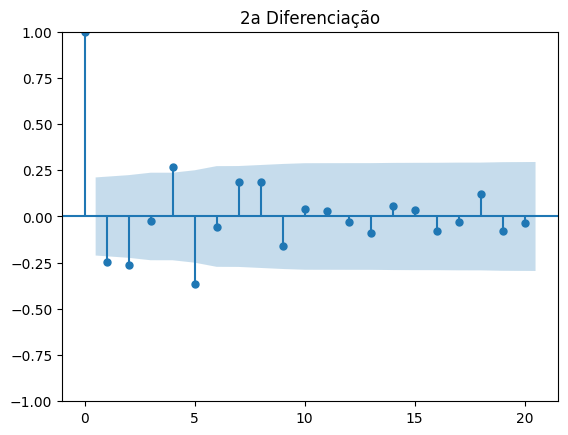

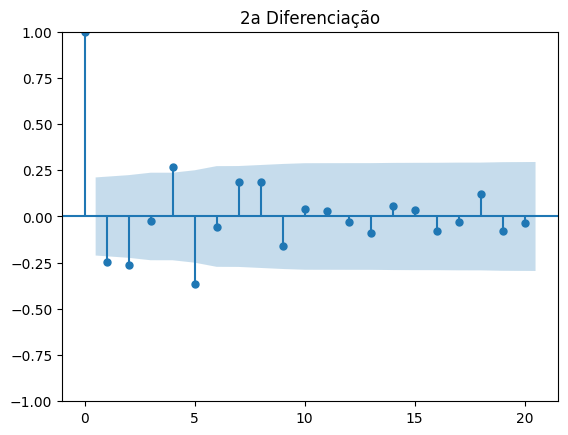

In [56]:
plot_acf(diff2, title='2a Diferenciação')

# Análise:
A análise dos gráficos sugere os seguintes hiperparâmetros:

In [57]:
p = 1
d = 1
q = 0

# PMDArima

In [58]:
%%time
!pip install --upgrade scikit-learn pmdarima

CPU times: user 69.3 ms, sys: 6.31 ms, total: 75.6 ms
Wall time: 8.67 s


In [59]:
from statsmodels.tsa.arima.model import ARIMA
train_values = train.sort_values(by='ds', ascending=True)['y']
model = ARIMA(train_values, order=(p,d,q))
model_fit = model.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   88
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -856.933
Date:                Thu, 20 Mar 2025   AIC                           1717.866
Time:                        10:20:20   BIC                           1722.774
Sample:                             0   HQIC                          1719.841
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2489      0.039     -6.327      0.000      -0.326      -0.172
sigma2      2.676e+07   8.62e-11   3.11e+17      0.000    2.68e+07    2.68e+07
Ljung-Box (L1) (Q):                   0.71   Jarque-

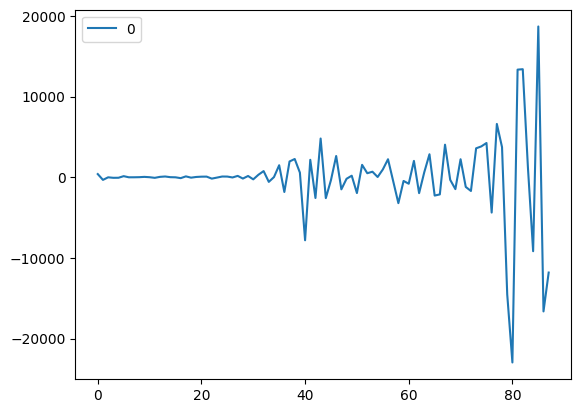

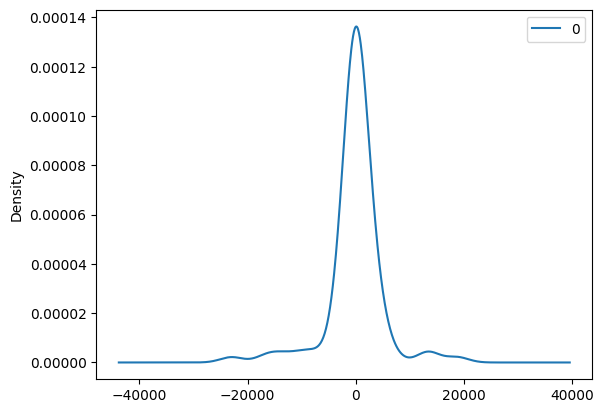

                  0
count     88.000000
mean    -133.644306
std     5111.669647
min   -22969.042945
25%     -469.883455
50%        8.944182
75%      808.107926
max    18684.953591


In [60]:
from matplotlib import pyplot
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [61]:

from sklearn.metrics import mean_squared_error
from math import sqrt
train_values = train.sort_values(by='ds', ascending=True)['y'].tolist()


predictions = list()
#walk-foward validation
test_values = test.sort_values(by='ds', ascending=True)['y'].tolist()
for t in range(len(test_values)):
  model = ARIMA(train_values, order=(1,2,0))
  # fit model
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  predictions.append(yhat)
  obs = test_values[t]
  train_values.append(obs)
  print(f'predicted={yhat}, expected={obs}')
#evaluate forecasts
rmse = sqrt(mean_squared_error(test_values, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes

predicted=37196.54426574357, expected=38483.125
predicted=29934.417487425744, expected=43193.234375
predicted=44938.36892659289, expected=45538.67578125
predicted=48436.64047474656, expected=37714.875
predicted=32167.78618493217, expected=31792.310546875
predicted=25446.785079451558, expected=19784.7265625
predicted=9155.110107331138, expected=23336.896484375
predicted=22875.03481924526, expected=20049.763671875
predicted=18627.90552526882, expected=19431.7890625
predicted=18081.009203121324, expected=20495.7734375
predicted=21101.55730626701, expected=17168.56640625
predicted=15047.177920773393, expected=16547.49609375
predicted=15177.487544244053, expected=23139.283203125
predicted=27785.610148714273, expected=23147.353515625
predicted=25001.901168800377, expected=28478.484375
predicted=32278.12578541818, expected=29268.806640625
predicted=31388.384040178993, expected=27219.658203125
predicted=25984.96433502426, expected=30477.251953125
predicted=32191.642763704458, expected=29230.11

In [62]:
plotter.plotly([train.rename(columns={'y':'train_y'}), test.rename(columns={'y':'test_y'}), pd.DataFrame({'ds':test['ds'], 'y':predictions, 'unique_id':'predictions'}).rename(columns={'y':'predict_y'})])

In [63]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1268.242
Date:                Thu, 20 Mar 2025   AIC                           2540.483
Time:                        10:20:26   BIC                           2546.124
Sample:                             0   HQIC                          2542.775
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4764      0.049     -9.630      0.000      -0.573      -0.379
sigma2      4.516e+07   1.58e-10   2.86e+17      0.000    4.52e+07    4.52e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):               125.48
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):              48.10   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""